# WORKFLOW for the creation of the ML potential at PZC

Requirements

- "MACE" => training and testing of the ML potential
- "LAMMPS" => MD
- "DEAL" python suite + "FLARE" => selection of new configurations
- "VASP" (or alternatively a DFT code) => single-point calculations for the labelling of the configurations 
- "DoubleRefernceMethod" python suite => handling of the DFT workflow

Sequence of STEPS:

1. **STEP 1**: Training  
2. **STEP 2**: Explorative MD simulation with LAMMPS  
3. **STEP 3**: *"DEAL"* selection of new configurations  
4. **STEP 4**: Single-point calculations for the labelling of the configurations


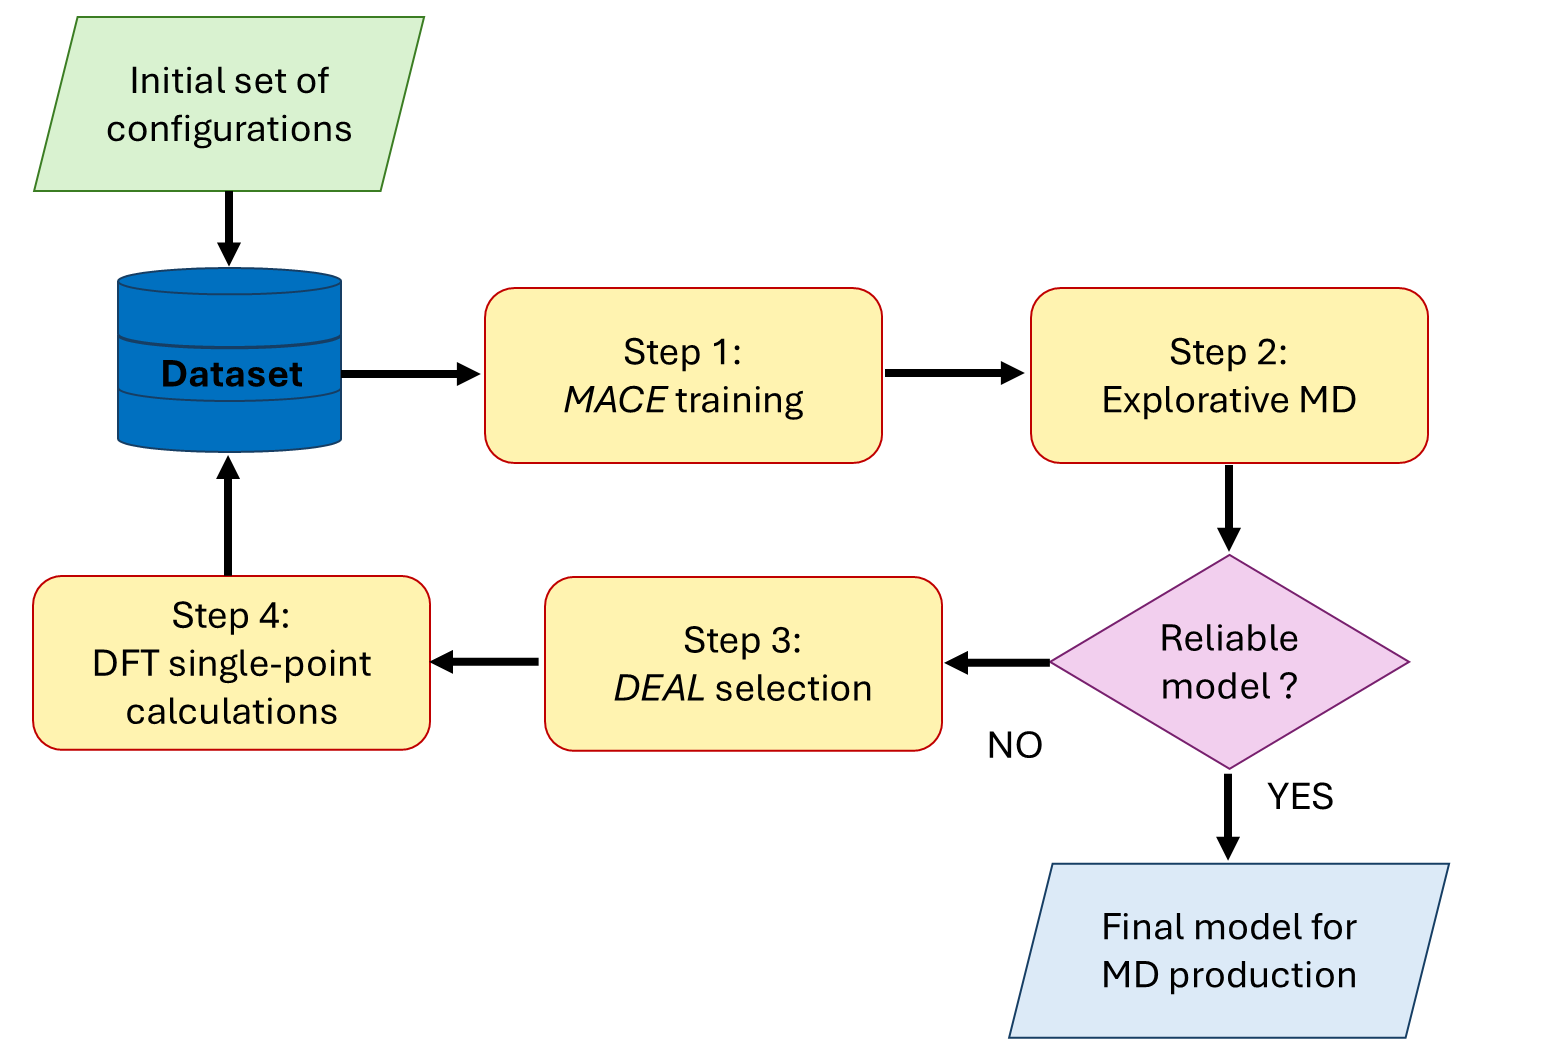

In [1]:
from IPython.display import Image
Image(filename='PZC_workflow.png',width=700, height=600)

These steps should be repeated until the generated ML potential is sufficiently reliable, i.e.:
- it allows for stable MD simulations
- it is accurate
- it grants converged physical properties (e.g., solvent density profile)

In [1]:
# Imports:
import numpy as np
import sys
import os
import glob
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import subprocess
from natsort import natsorted

from ase import Atom
from ase.io import read,write

# Path to the workflow_utils directory
# !!! MODIFY IF NEEDED !!!
workflow_utils_path = "../"
sys.path.append(workflow_utils_path)

# STEP 1: Training
Here we generate 4 equivalent ML potentials.
Each one is trained on a different partition of the dataset, using a different random seed for the weight initialization

Remark: 
if this is the first active learning iteration, you should have already assembled a preliminary training set at dataset in the "Training/Dataset/" folder.
See our article for more details about the strategy to assemble this dataset.

In [3]:
os.chdir('Training')

print(natsorted(os.listdir()))

# This directory includes:
# 1) The dataset (in "Dataset") => Here, there are the ext-xyz files with the energies, forces, Bader charges etc...
#                                  - IF this is the first cycle of active learning, the initial dataset can be composed 
#                                    by configurations generated via AIMD or foundation-model ML potentials (e.g., MACE-MP-0).
#                                  - IF this is NOT the first cycle of active learning, the dataset is the one of the
#                                    previous cycle + the newly labelled configurations.  

# 2) The folders where the 4 different ML models will be trained (in "MLFF1", "MLFF2", "MLFF3", "MLFF4").
# 3) sbatch_train_mace_template => template of the sbatch script for the MACE training of the ML potential.
                                 
os.chdir('..')

['Dataset', 'MLFF1', 'MLFF2', 'MLFF3', 'MLFF4', 'sbatch_train_mace_template']


Create the different input scripts for the MACE training of the 4 different ML models

In [ ]:
# Customize the "sbatch_train_mace_template" script
# Verify that the sbatch_train_mace_template script activates the correct conda env with MACE installed

from workflow_utils.python_utils import create_mace_train_scripts
help(create_mace_train_scripts)


Help on function create_mace_train_scripts in module workflow_utils.python_utils:

create_mace_train_scripts(num_models, template_script, output_prefix)
    This script creates the sbatch scripts for the training of the ML potential with MACE.
    The sbatch scripts are saved in the folder "MLFF1", "MLFF2" etc...

    Inputs:
    - num_models: int, number of ML models to be trained (default: 4)
    - template_script: str, name of the template script (default: sbatch_train_mace_template)
    - output_prefix: str, prefix of the output script (default: sbatch_train_mace_model_)



In [5]:
os.chdir('Training')
create_mace_train_scripts(
                        num_models=4, 
                        template_script="sbatch_train_mace_template", 
                        output_prefix="sbatch_train_mace_model_"
                        )
os.chdir('..')

Creating the sbatch scripts for the training of the ML potentials:

Model 1 with seed 300
Model 2 with seed 360
Model 3 with seed 420
Model 4 with seed 480


Create the different partitions of the dataset for the ML models

In [6]:
from workflow_utils.python_utils import generate_dataset_partition

help(generate_dataset_partition)

Help on function generate_dataset_partition in module workflow_utils.python_utils:

generate_dataset_partition(fraction_4_model, fraction_val)
    This script creates 4 different training/validation partitions of the dataset.
    Each partition will be used to train a different ML-FF.
    Each model will be validated on a fraction the selected partition.
    The training and validation sets are saved in the folders "MLFF1", "MLFF2" etc...

    Inputs:
    - fraction_4_model: float, fraction of the dataset that is used for a specific ML-FF
    - fraction_val: float, fraction of the dataset for a specific ML-FF that is used for validation



In [7]:
os.chdir('Training/Dataset')

generate_dataset_partition(fraction_4_model=0.7, fraction_val=0.15)

os.chdir('../..')

Number of configurations for each ML model:

Train: 1895
Validation: 331


Moving the training and validation sets

Terminated !


Run the training of the 4 different ML models in MACE

In [ ]:
# Do NOT run locally, but submit the jobs to a cluster (Multi-GPU training is recommended)

os.chdir('Training/')

for i in range(1,5):
    print(f"Submitting the training of model {i}")
    os.chdir(f'MLFF{i}')
    os.system(f"sbatch sbatch_train_mace_model_{i}")
    os.chdir('../')

os.chdir('../')

Submitting the training of model 1
Submitted batch job 20821925
Submitting the training of model 2
Submitted batch job 20821926
Submitting the training of model 3
Submitted batch job 20821927
Submitting the training of model 4
Submitted batch job 20821929


# STEP 2: Explorative MD simulation with LAMMPS

Convert the trained MACE model to the LAMMPS format.

In [8]:
model_name="MACE_Cu_H2O_PZC_1_stagetwo_compiled.model"
os.system(f"cp Training/MLFF1/{model_name} MD/")

# if needed, change permission to the file
#os.system("chmod +x MD/Mace2Lammps.sh")

# Specify the path of the environment in which MACE is installed
ENV_PATH="/leonardo/pub/userexternal/mbianchi/mace_v0.3.13"
os.system(f"conda run -p {ENV_PATH} MD/Mace2Lammps.sh {ENV_PATH} MD/{model_name}")

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Only one head found in the model: Default. Skipping selection.
LAMMPS model created



/leonardo/pub/userexternal/mbianchi/mace_v0.3.13/lib/python3.13/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/leonardo/pub/userexternal/mbianchi/mace_v0.3.13/lib/python3.13/site-packages/mace/cli/create_lammps_model.py:79: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(
/leonardo/pub/userexternal/mbianchi/mace_v0.3.13/lib/python3.13/site-packages/torch/serialization.py:1488: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(



0

Run the MD simulation with LAMMPS

In [ ]:
# Customize the MD parameters in the "MACE_Cu_111_H2O_PZC_lammps.in" script
# Do NOT run locally, but submit the job to a cluster

# Verify the setting in the sbatch script

os.chdir('MD/')
os.system("sbatch sbatch_lammps_mace")   
os.chdir('..')

Submitted batch job 20922952


Evaluate the solvent density profile from the MD trajectory

In [2]:
# Plot and save to file the density profile

# Monitoring the convergence of the density profile during the different active learning cycles provide a 
# good indication of the reliability of the ML potential

from workflow_utils.python_utils import compute_solvent_density_profile

help(compute_solvent_density_profile)

Help on function compute_solvent_density_profile in module workflow_utils.python_utils:

compute_solvent_density_profile(MD_file, format, sigma, z_surf, n_bin)
    This script computes the density profile of the water solvent along the z direction via Kernel Density Estimation (KDE).
    The density profile is computed for each atomic species present in the system and with respect to the surface of the metal.

    Inputs:
        - MD_file: string, file containing the MD trajectory
        - format: str, ase format of the MD trajectory
        - sigma: float, the standard deviation of the Gaussian kernel used for the KDE
        - z_surf: float, z position of the metal surface with respect to the center of the slab (in Angstrom)
        - n_bin: int, number of grid points

    Outputs:
        - bin_center: array, centers of each bin of the density profile
        - density_O_g_cm3: array, density profile of oxygen in g/cm^3
        - density_H_g_cm3: array, density profile of hydrogen

<>:13: SyntaxWarning: invalid escape sequence '\A'
<>:13: SyntaxWarning: invalid escape sequence '\A'
/scratch_local/ipykernel_3304023/1217968838.py:13: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('z - z$_{surf}$  [$\AA$]',fontsize=15)


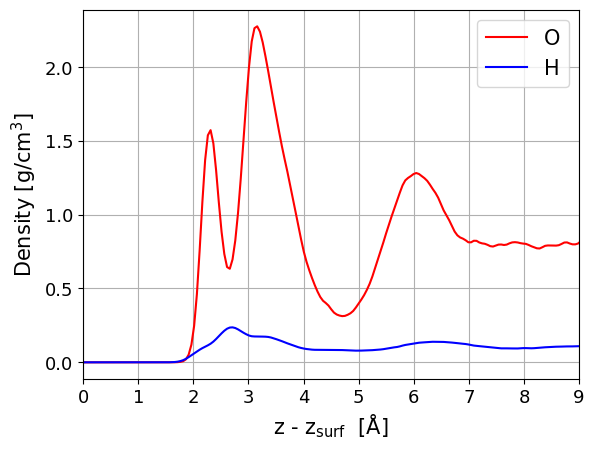

In [3]:
bin_center, density_O_g_cm3_kde, density_H_g_cm3_kde = compute_solvent_density_profile(
                                                                                        MD_file='MD/Cu_H2O_NVT.dump', 
                                                                                        format="lammps-dump-text", 
                                                                                        sigma=0.06, 
                                                                                        z_surf=5.165,
                                                                                        n_bin=200
                                                                                        )

plt.plot(bin_center,density_O_g_cm3_kde,'r',label='O')
plt.plot(bin_center,density_H_g_cm3_kde,'blue',label='H')
params = {'mathtext.default': 'regular' } 
plt.rcParams.update(params)
plt.xlabel('z - z$_{surf}$  [$\AA$]',fontsize=15)
plt.ylabel('Density [g/cm$^{3}$]',fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.grid()
plt.xlim([0,9])
plt.legend(fontsize=15)
plt.show()

# Save to file the density profile
# Specify the number of active learning iteration
round=1

os.makedirs(f"MD/results_round_{round}",exist_ok=True)
np.savetxt(f'MD/results_round_{round}/z_profile_PZC_kde.dat',bin_center)
np.savetxt(f'MD/results_round_{round}/O_profile_PZC_kde.dat',density_O_g_cm3_kde)
np.savetxt(f'MD/results_round_{round}/H_profile_PZC_kde.dat',density_H_g_cm3_kde)

Compute the standard deviation of the forces predicted by the 4 different ML models

In [ ]:
# Do NOT run locally, but submit the job to a cluster

# Verify the settining in the sbatch_evaluation_std_dev  script

os.chdir('MD/std_dev/')
os.system("sbatch sbatch_evaluation_std_dev")   
os.chdir('../..')

Submitted batch job 20981989


# CHECK
Decide whether to proceed to another active learning iteration or exit from the cycle.

Plot a physical observable (e.g., the O density profile) along the active learning iterations to evaluete convergence.

<>:11: SyntaxWarning: invalid escape sequence '\A'
<>:11: SyntaxWarning: invalid escape sequence '\A'
/scratch_local/ipykernel_3304023/1285373800.py:11: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('z - z$_{surf}$  [$\AA$]',fontsize=15)


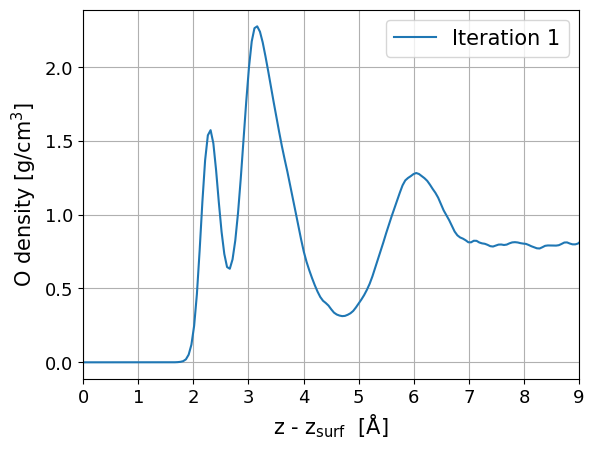

In [8]:
file_paths = glob.glob("MD/results_round_*")
counter=0
for path in natsorted(file_paths):
    z=np.loadtxt(path+"/z_profile_PZC_kde.dat")
    O=np.loadtxt(path+"/O_profile_PZC_kde.dat")
    counter=counter+1
    plt.plot(z,O,label=f"Iteration {counter}")

params = {'mathtext.default': 'regular' } 
plt.rcParams.update(params)
plt.xlabel('z - z$_{surf}$  [$\AA$]',fontsize=15)
plt.ylabel('O density [g/cm$^{3}$]',fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.grid()
plt.xlim([0,9])
plt.legend(fontsize=15)
plt.show()
    

If the density profile remains unchanged during subsequent cycles, you may be satisfied with the resulting model and choose to exit the active learning cycle.

Otherwise continue with the following cell of the active learning cycle...

# STEP 3: "DEAL" selection of new configurations

The following notebook cells are a mirror of the tutorial notebook of the "DEAL" suite available at:
https://github.com/luigibonati/DEAL/tree/new_deal

Import DEAL

In [ ]:
# !!! Make sure to change the path to the DEAL code folder !!!

path_DEAL_code="/path/to/DEAL/code/folder"
sys.path.append(path_DEAL_code)
from deal.input import create_deal_input
from deal.utils import compute_histogram,paletteFessa

Load the MD trajectory

In [14]:
path_file="MD/std_dev/"

traj = read(path_file+'MACE_Cu_H2O_PZC_with_std_dev.xyz',index=':')
print("Total number of configurations:",len(traj))

Total number of configurations: 5001


PRE-POCESSING OF THE TRAJECTORY 

Pre-selection via query-by-committee (optional, but recommended)

Pre-selection by uncertainty: 2059/5001 frames


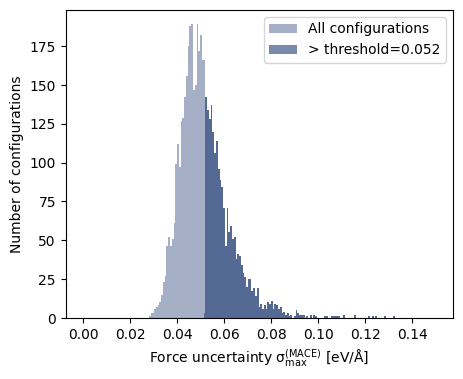

In [15]:
# Carefully select the threshold
# - too low => too many configurations selected for DFT labelling
# - too high => selection of likely unfeasible configurations

threshold = 0.052
max_threshold = 3*threshold

if threshold is not None:
    try:
        # define the uncertainty of a frame as the max uncertainty on force components
        uncertaintyx = np.asarray([atoms.get_array("std_dev_fx").max() for atoms in traj])
        uncertaintyy = np.asarray([atoms.get_array("std_dev_fy").max() for atoms in traj])
        uncertaintyz = np.asarray([atoms.get_array("std_dev_fz").max() for atoms in traj])
        uncertainty=np.asarray([max(uncertaintyx[i],uncertaintyy[i],uncertaintyz[i]) for i in range(0,len(traj))])
        
        # save it in atoms.info
        for i,atoms in enumerate(traj):
            atoms.info['uncertainty'] = uncertainty[i]
            
        preselection = ( uncertainty > threshold ) & ( uncertainty < max_threshold )

        print(f'Pre-selection by uncertainty: {preselection.sum()}/{len(traj)} frames')

        bins_unc = np.linspace(0, 0.15, 200)

        x,(h1,h2) = compute_histogram(uncertainty,bins_unc,threshold=threshold)
        fig, ax = plt.subplots(figsize=(5,4),dpi=100)
        ax.bar(x,h1,width=(x[1]-x[0]),color='fessa0',alpha=0.4,label='All configurations')
        ax.bar(x,h2,width=(x[1]-x[0]),color='fessa0',alpha=0.6,label=f'> threshold={threshold}')
        ax.set_xlabel(r'Force uncertainty $\sigma^{(MACE)}_{max}$ [eV/$\AA$]')
        ax.set_ylabel('Number of configurations')
        ax.legend(frameon=True)
        plt.show()
    except Exception as e:
        print('No pre-selection: uncertainty not found.')
        preselection = np.ones(len(traj),dtype=bool)

In [16]:
# shuffle trajectory
shuffle = True
seed = 42 

idx = np.argwhere(preselection)[:,0]
if shuffle:
    np.random.seed(seed)
    np.random.shuffle(idx)

traj_input = [traj[i] for i in idx]

# save trajectory

path_DEAL="DEAL/"
write(path_DEAL+'All_Data.xyz',traj_input)

DEAL SELECTION

Create input

Paremeters:
* `config_path`: file which contains the default values for descriptors etc.
* `cutoff`: the cutoff for the construction of the local environments (can be a single value or a matrix )
* `deal_threshold`: the threshold for selecting the new structures

In [ ]:
# set DEAL parameters
cutoffs = [4.5,5.5]
deal_thresholds = [0.1,0.15]

for cutoff in cutoffs:
    for deal_threshold in deal_thresholds:
        run_folder=path_DEAL+f"threshold-{deal_threshold:.3f}/cutoff-{cutoff}/"

        create_deal_input(path_DEAL+'All_Data.xyz',
                        folder=run_folder,
                        config_path=path_DEAL_code+'deal/configs/default.yaml',
                        cutoff = cutoff,
                        threshold = deal_threshold,
                        copy_traj=False) # create a symbolic link in each folder 
        
        # customize sbatch script with the correct settings
        os.system(f'sed "s+JOBNAME+DEAL_cut_{cutoff}_thr_{deal_threshold}+g" {path_DEAL}/sbatch_new_deal_template > {run_folder}/sbatch_new_deal')

Run DEAL

In [ ]:
# Do NOT run locally, but submit the jobs to a cluster

for cutoff in cutoffs:
    for deal_threshold in deal_thresholds:
        run_folder=path_DEAL+f"threshold-{deal_threshold:.3f}/cutoff-{cutoff}/"
        print(f'Submitting DEAL with cutoff={cutoff} and threshold={deal_threshold}')
        os.chdir(run_folder)
        os.system("sbatch sbatch_new_deal")   
        os.chdir('../../../')

Submitting DEAL with cutoff=4.5 and threshold=0.1
Submitted batch job 20983828
Submitting DEAL with cutoff=4.5 and threshold=0.15
Submitted batch job 20983829
Submitting DEAL with cutoff=5.5 and threshold=0.1
Submitted batch job 20983831
Submitting DEAL with cutoff=5.5 and threshold=0.15
Submitted batch job 20983832


Results of DEAL

DEAL Selection
Cutoff 4.500, threshold 0.100: 196/2059 structures
Cutoff 4.500, threshold 0.150: 109/2059 structures


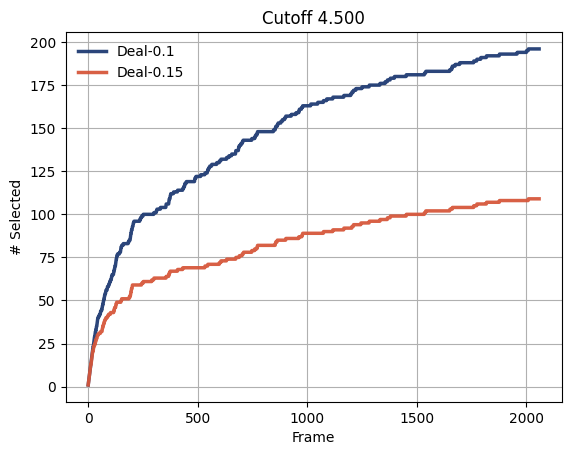

Cutoff 5.500, threshold 0.100: 150/2059 structures
Cutoff 5.500, threshold 0.150: 85/2059 structures


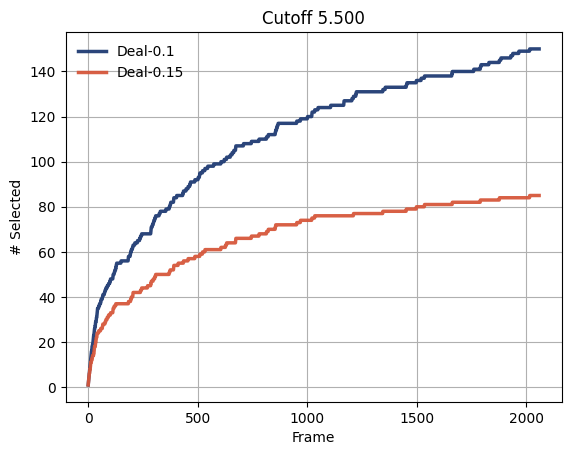

In [19]:
print('DEAL Selection')
traj_all = read(path_DEAL+'All_Data.xyz',index=':')
for cutoff in cutoffs:
    traj_deals = {}
    for deal_threshold in deal_thresholds:
        run_folder=path_DEAL+f"threshold-{deal_threshold:.3f}/cutoff-{cutoff}/"
        traj = read(run_folder+'deal_selected.xyz',index=':')
        traj_deals[deal_threshold] = traj
        print(f'Cutoff {cutoff:.3f}, threshold {deal_threshold:.3f}: {len(traj)}/{len(traj_all)} structures')

        colors = mpl.colormaps['fessa'](np.linspace(0, 1, len(traj_deals)))

    fig, ax = plt.subplots()

    for k,(deal_threshold,traj_deal) in enumerate(traj_deals.items()):
        selected_ids = [ atoms.info['step'] for atoms in traj_deal ]
        selection_curve = [np.sum(np.asarray(selected_ids)<=i) for i in range(len(traj_all))]
        ax.plot(selection_curve,label=f'Deal-{deal_threshold}',linewidth=2.5,alpha=0.95, color=colors[k])

    ax.set_title(f'Cutoff {cutoff:.3f}')
    ax.set_xlabel('Frame')
    ax.set_ylabel('# Selected')
    ax.legend(frameon=False)
    ax.grid()
    plt.show()

View selection via chemiscope

In [20]:
import chemiscope
from deal.utils import create_chemiscope_input

# SPECIFY chosen cutoff and threshold
cutoff = 5.5
deal_threshold = 0.15

run_folder=path_DEAL+f"threshold-{deal_threshold:.3f}/cutoff-{cutoff}/"

## if the chemiscope file is not already generated, it can be done with the following line
#chemiscope_input = create_chemiscope_input(trajectory = run_folder+'deal_selected.xyz',
#                                           filename=run_folder+'deal_chemiscope.json.gz')

chemiscope.show_input(f'{run_folder}/deal_chemiscope.json.gz')

<ChemiscopeWidget(meta={'name': 'DEAL selection'}, settings={'structure': [{'atoms': False, 'bonds': False, 's…

Create the POSCAR files for the selected configurations

In [21]:
path_poscar="DEAL/POSCAR_temp/"
os.makedirs(path_poscar,exist_ok=True)

# SPECIFY chosen cut-off and threshold
cutoff = 5.5
deal_threshold = 0.15

run_folder=path_DEAL+f"threshold-{deal_threshold:.3f}/cutoff-{cutoff}/"
Dataset_selected=read(run_folder+'deal_selected.xyz',index=':',format='extxyz')

counter_configuration=0
for i,snap in enumerate(Dataset_selected):
    snap.wrap()
    write(path_poscar+f'POSCAR_{i}',snap,format='vasp')
    counter_configuration=counter_configuration+1

print(f"Total number of configurations for the DFT labelling: {counter_configuration}\n")

Total number of configurations for the DFT labelling: 85



# STEP 4: Single-point calculations for the labelling of the configurations

In [22]:
os.chdir('DFT')

print(natsorted(os.listdir()))

# This directory includes:
# 1) sbatch_vasp_ase_template => the job submission script to run the VASP single-point calculations via ASE calculator
#                       Check to load the correct module and conda environment and set the correct paths
# 2) DoubleRefernceWorkflow_PZC.py => python script to handle the DFT workflow at PZC conditions
#                                     Check and customize the DFT parameters in the script
#
# 3) Different folders (e.g., "case_0", "case_1" etc..) => each folder will contain the output of the DFT calculations
                                 
os.chdir('..')

['DoubleReference_workflow_PZC.py', 'case_0', 'case_1', 'case_2', 'case_3', 'case_4', 'sbatch_vasp_ase_template']


Create the input scripts for each configuration

In [23]:
from workflow_utils.python_utils import create_DFT_scripts
help(create_DFT_scripts)

Help on function create_DFT_scripts in module workflow_utils.python_utils:

create_DFT_scripts(
    num_configurations,
    case,
    template_script,
    path_poscar,
    python_calc_file,
    customize_potential,
    V_case=None,
    extra_elec=None,
    C_guess=None
)
    This script creates the sbatch scripts for the DFT single-points.
    The sbatch scripts are saved in folders "case_0', 'case_1' etc...

    Inputs:
        - num_configurations: int, number of configurations to label
        - case: string, it identifies the case (e.g., "PZC", "m05" etc...)
        - template_script: string, name of the template script (default: sbatch_vasp_ase_template)
        - path_poscar: string, path to the POSCAR files for the DFT single-points
        - python_calc_file: string, path to the python file containing the VASP calculator
        - customize_potential: bool, logical switch to specify extra parameters for constant-potential calculation (default: False)
        - V_case: array, of

In [ ]:
os.chdir('DFT')
create_DFT_scripts(
                    num_configurations=counter_configuration, 
                    case="PZC", 
                    template_script='sbatch_vasp_ase_template', #Verify the settings in this tempate for the sbatch script 
                    path_poscar='../../DEAL/POSCAR_temp/', 
                    python_calc_file='DoubleReference_workflow_PZC.py',
                    customize_potential=False
                    )
os.chdir('..')

Run the DFT single-point calculations

In [ ]:
# Do NOT run locally, but submit the jobs to a cluster

os.chdir('DFT/PZC/')

# For sake of simplicity, only 5 configurations are evaluated at DFT level in this tutorial
#counter_configuration=5

for i in range(0,counter_configuration):
    print(f"Submitting single-point number {i}")
    os.chdir(f'case_{i}')
    os.system(f"sbatch sbatch_vasp_ase")
    os.chdir('../')

os.chdir('../../')

Submitting single-point number 0
Submitted batch job 20991421
Submitting single-point number 1
Submitted batch job 20991422
Submitting single-point number 2
Submitted batch job 20991423
Submitting single-point number 3
Submitted batch job 20991424
Submitting single-point number 4
Submitted batch job 20991425


Check results of the DFT calculations

In [25]:
# After the DFT calculations are completed, check that all the calculations reached convergence / ended smoothly

# Find all matching files
file_paths = glob.glob("DFT/PZC/case_*/case_*/")

print("Check convergence:\n")
# Search for lines containing both 'aborting' and 'unconverged'
# When VASP does not converge, it prints a line like:
# "aborting loop EDIFF was not reached (unconverged)"
for path in file_paths:
        
        file=path+"/OUTCAR_neutral_no_vaccum"
        with open(file, 'r') as file:

            # Flag to check if Vasp ended smoothly
            end=False
            for line_num, line in enumerate(file, start=1):
                if 'aborting' in line: # VASP ends smoothly
                    end=True
                    
                    if 'aborting' in line and 'unconverged' in line: # VASP did not converge
                        print(f"VASP did not converge in {path}\n")
                        
                    # else: Vasp converged, so do nothing
                        
            if end is False:# Not found 'aborting' string => VASP did not finish smoothly, check what happened
                print(f"VASP did not finish smoothly in {path}\n")
print("Done")

print("Check and eventually remove the folders where VASP did not converge or did not finish smoothly")

Check convergence:

Done
Check and eventually remove the folders where VASP did not converge or did not finish smoothly


Extract and save the DFT results in a single ext-xyz file 

In [2]:
# Collect energy, forces, Bader charges etc.. from the different configurations in a single ext-xyz file
# The ext-xyz file will be moved to the dataset folder for the next active learning cycle

round_number=1
name_dataset=f"dataset_Cu_H2O_111_PZC_round{round_number}.xyz"

os.chdir('DFT/PZC/')
pwd=os.getcwd()

file_paths=glob.glob("case_*/case_*/")

for file in file_paths:
    data=read(file+'OUTCAR_neutral_no_vaccum.xyz',format='extxyz')
    write(pwd+'/'+name_dataset,data,format="extxyz",append=True)

shutil.copy(pwd+'/'+name_dataset, "../../Training/Dataset/"+name_dataset)

os.chdir("../../")

Ready to start a new round of active learning !